In [10]:
import scipy.sparse as sps
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample
import pandas as pd
import numpy as np
from pandas.api.types import CategoricalDtype
from Evaluation.Evaluator import EvaluatorHoldout
from Data_Handler.DataReader import DataReader
import scipy.sparse as sps
from collections import Counter
from tqdm import tqdm
# imports for .env usage
import os
from dotenv import load_dotenv
load_dotenv()



True

In [11]:
from Data_Handler.DataReader import DataReader 
dataReader=DataReader()
urm=dataReader.load_augmented_binary_urm()
powerful_urm=dataReader.load_powerful_binary_urm()

URM_train, URM_validation = split_train_in_two_percentage_global_sample(urm, train_percentage = 0.9)
train_powerful, val_powerful = split_train_in_two_percentage_global_sample(powerful_urm, train_percentage = 0.9)
#train_pad, val_pad = split_train_in_two_percentage_global_sample(urm_pad, train_percentage = 0.9)

In [12]:
profile_length = np.ediff1d(sps.csr_matrix(URM_train).indptr)
profile_length, profile_length.shape

(array([59, 19, 97, ..., 21, 51, 21], dtype=int32), (41629,))

In [13]:
block_size = int(len(profile_length)*0.05)
block_size

2081

In [14]:
sorted_users = np.argsort(profile_length)
sorted_users

array([38965, 38400, 25061, ..., 19407,  8693, 12454])

In [15]:
for group_id in range(0, 20):
    start_pos = group_id * block_size
    end_pos = min((group_id+1) * block_size, len(profile_length))
    
    users_in_group = sorted_users[start_pos:end_pos]
    
    users_in_group_p_len = profile_length[users_in_group]
    
    print("Group {}, #users in group {}, average p.len {:.2f}, median {}, min {}, max {}".format(
        group_id, 
        users_in_group.shape[0],
        users_in_group_p_len.mean(),
        np.median(users_in_group_p_len),
        users_in_group_p_len.min(),
        users_in_group_p_len.max()))

Group 0, #users in group 2081, average p.len 11.41, median 12.0, min 5, max 13
Group 1, #users in group 2081, average p.len 14.34, median 14.0, min 13, max 15
Group 2, #users in group 2081, average p.len 15.96, median 16.0, min 15, max 17
Group 3, #users in group 2081, average p.len 17.37, median 17.0, min 17, max 18
Group 4, #users in group 2081, average p.len 18.52, median 19.0, min 18, max 19
Group 5, #users in group 2081, average p.len 19.70, median 20.0, min 19, max 20
Group 6, #users in group 2081, average p.len 20.92, median 21.0, min 20, max 22
Group 7, #users in group 2081, average p.len 22.28, median 22.0, min 22, max 23
Group 8, #users in group 2081, average p.len 23.53, median 24.0, min 23, max 24
Group 9, #users in group 2081, average p.len 25.02, median 25.0, min 24, max 26
Group 10, #users in group 2081, average p.len 26.58, median 27.0, min 26, max 27
Group 11, #users in group 2081, average p.len 28.46, median 28.0, min 27, max 29
Group 12, #users in group 2081, average

In [16]:
from Recommenders.NonPersonalizedRecommender import TopPop
from Recommenders.KNN.UserKNNCFRecommender import UserKNNCFRecommender
from Recommenders.KNN.ItemKNNCFRecommender import ItemKNNCFRecommender
from Recommenders.SLIM.Cython.SLIM_BPR_Cython import SLIM_BPR_Cython
from Recommenders.SLIM.SLIMElasticNetRecommender import SLIMElasticNetRecommender
from Recommenders.GraphBased.P3alphaRecommender import P3alphaRecommender
from Recommenders.GraphBased.RP3betaRecommender import RP3betaRecommender
from Recommenders.MatrixFactorization.Cython.MatrixFactorization_Cython import MatrixFactorization_BPR_Cython, MatrixFactorization_FunkSVD_Cython, MatrixFactorization_AsySVD_Cython
from Recommenders.MatrixFactorization.PureSVDRecommender import PureSVDRecommender
from Recommenders.MatrixFactorization.IALSRecommender import IALSRecommender
from Recommenders.MatrixFactorization.NMFRecommender import NMFRecommender
from Recommenders.KNN.ItemKNNCBFRecommender import ItemKNNCBFRecommender
from Recommenders.KNN.ItemKNN_CFCBF_Hybrid_Recommender import ItemKNN_CFCBF_Hybrid_Recommender
from Recommenders.FactorizationMachines.LightFMRecommender import LightFMItemHybridRecommender

MAP_recommender_per_group = {}

collaborative_recommender_class = {
        "SLIMElasticNetRecommender": SLIMElasticNetRecommender,
        "UserKNNCF": UserKNNCFRecommender,
        "ItemKNNCF": ItemKNNCFRecommender,
        "RP3beta": RP3betaRecommender,
        "TopPop": TopPop,
}

recommender_object_dict = {}
recommended_items_for_each_user = {}

for label, recommender_class in collaborative_recommender_class.items():
    if(label == "SLIMElasticNetRecommender"):
        recommender_object = recommender_class(train_powerful)
        recommender_object.fit()
    else:
        recommender_object = recommender_class(URM_train)
        recommender_object.fit()
    recommender_object_dict[label] = recommender_object


SLIMElasticNetRecommender: URM Detected 338 ( 1.2%) items with no interactions.
SLIMElasticNetRecommender: Processed 5579 (19.9%) in 5.00 min. Items per second: 18.59
SLIMElasticNetRecommender: Processed 11460 (41.0%) in 10.00 min. Items per second: 19.10
SLIMElasticNetRecommender: Processed 17313 (61.9%) in 15.00 min. Items per second: 19.23
SLIMElasticNetRecommender: Processed 23106 (82.6%) in 20.00 min. Items per second: 19.25
SLIMElasticNetRecommender: Processed 27968 (100.0%) in 24.39 min. Items per second: 19.11
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 41629 (100.0%), 582.14 column/sec. Elapsed time 1.19 min
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 24507 (100.0%), 634.65 column/sec. Elapsed time 38.62 sec
RP3betaRecommender: Similarity column 24507 (100.0%), 1742.74 column/sec. Elapsed time 14.06 sec


In [17]:
evaluator=EvaluatorHoldout(URM_validation, cutoff_list=[10])

EvaluatorHoldout: Ignoring 2806 ( 6.7%) Users that have less than 1 test interactions


In [18]:
from evaluator import evaluate
cutoff = 10

for group_id in range(0, 20):
    
    start_pos = group_id*block_size
    end_pos = min((group_id+1)*block_size, len(profile_length))
    
    users_in_group = sorted_users[start_pos:end_pos]
    
    users_in_group_p_len = profile_length[users_in_group]
    
    print("Group {}, #users in group {}, average p.len {:.2f}, median {}, min {}, max {}".format(
        group_id, 
        users_in_group.shape[0],
        users_in_group_p_len.mean(),
        np.median(users_in_group_p_len),
        users_in_group_p_len.min(),
        users_in_group_p_len.max()))
    
    
    users_not_in_group_flag = np.isin(sorted_users, users_in_group, invert=True)
    users_not_in_group = sorted_users[users_not_in_group_flag]
    
    evaluator_test = EvaluatorHoldout(URM_validation, cutoff_list=[cutoff], ignore_users=users_not_in_group)
    evaluator_power = EvaluatorHoldout(val_powerful, cutoff_list=[cutoff], ignore_users=users_not_in_group)
    #evaluator_pad = EvaluatorHoldout(val_pad, cutoff_list=[cutoff], ignore_users=users_not_in_group)

    for label, recommender in recommender_object_dict.items():
        if(label == "SLIMElasticNetRecommender"):
            #map=evaluate(recommended_items_for_each_user,val_powerful,target)
            result_df, _ = evaluator_power.evaluateRecommender(recommender)
        
        else:
            #map=evaluate(recommended_items_for_each_user,URM_validation,target)
            result_df, _ = evaluator_test.evaluateRecommender(recommender)
        if label in MAP_recommender_per_group:
            MAP_recommender_per_group[label].append(result_df.loc[cutoff]["MAP"])
            #MAP_recommender_per_group[label].append(map)
        else:
            MAP_recommender_per_group[label] = [result_df.loc[cutoff]["MAP"]]
            #MAP_recommender_per_group[label] = [map]


Group 0, #users in group 2081, average p.len 11.41, median 12.0, min 5, max 13
EvaluatorHoldout: Ignoring 2806 ( 6.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 39548 Users
EvaluatorHoldout: Ignoring 2922 ( 7.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 39548 Users
EvaluatorHoldout: Processed 1551 (100.0%) in 1.48 sec. Users per second: 1051
EvaluatorHoldout: Processed 1783 (100.0%) in 1.73 sec. Users per second: 1032
EvaluatorHoldout: Processed 1783 (100.0%) in 1.82 sec. Users per second: 979
EvaluatorHoldout: Processed 1783 (100.0%) in 1.34 sec. Users per second: 1334
EvaluatorHoldout: Processed 1783 (100.0%) in 1.51 sec. Users per second: 1178
Group 1, #users in group 2081, average p.len 14.34, median 14.0, min 13, max 15
EvaluatorHoldout: Ignoring 2806 ( 6.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 39548 Users
EvaluatorHoldout: Ignoring 2922 ( 7.0%) Users that have less than 1 test inte

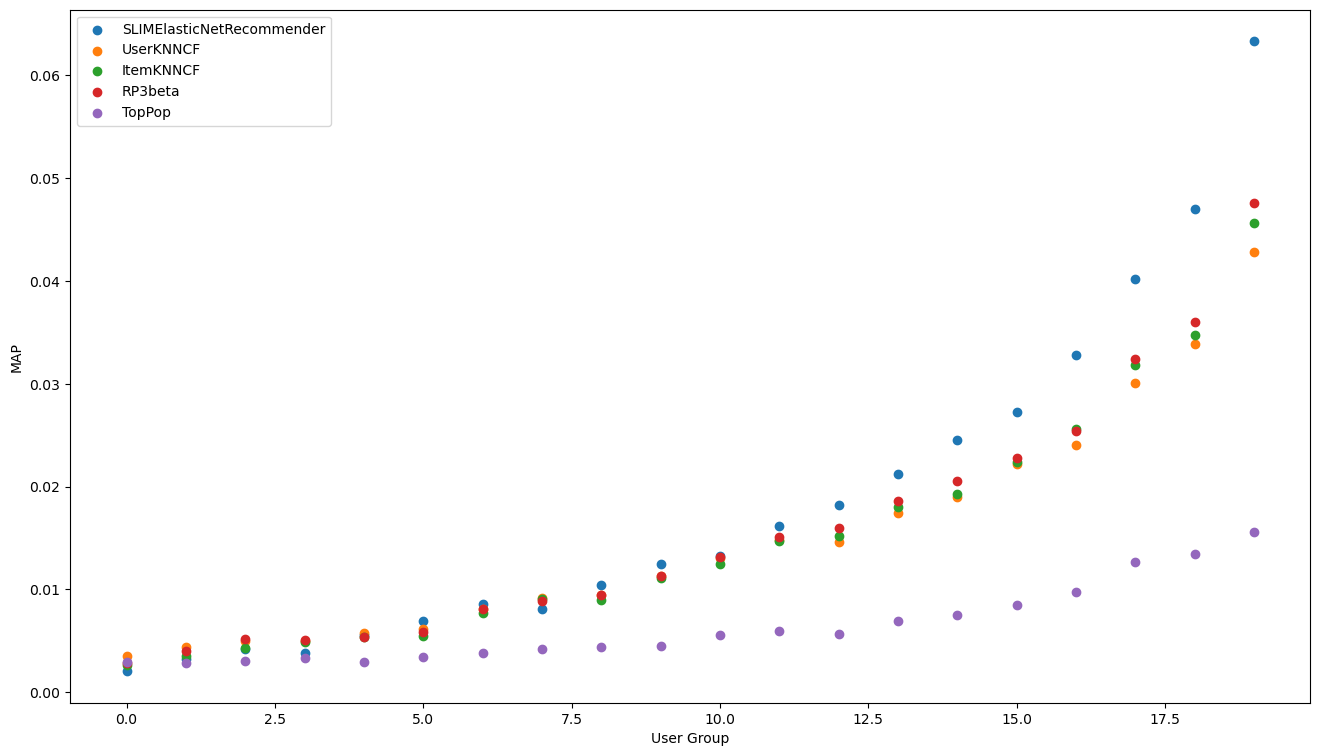

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline  

_ = plt.figure(figsize=(16, 9))
for label, recommender in recommender_object_dict.items():
    results = MAP_recommender_per_group[label]
    plt.scatter(x=np.arange(0,len(results)), y=results, label=label)
plt.ylabel('MAP')
plt.xlabel('User Group')
plt.legend()
plt.show()